In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

/home/arnaudon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


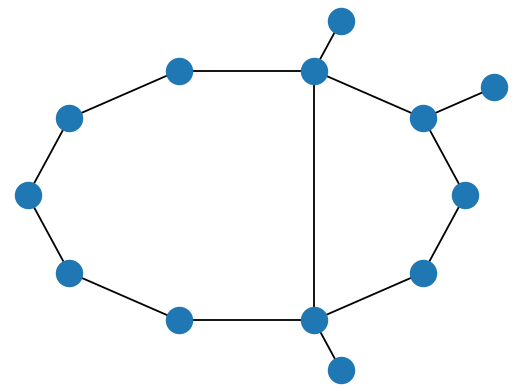

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

Total lenght: 8.082452920089256
Average lenght: 0.7347684472808415


In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


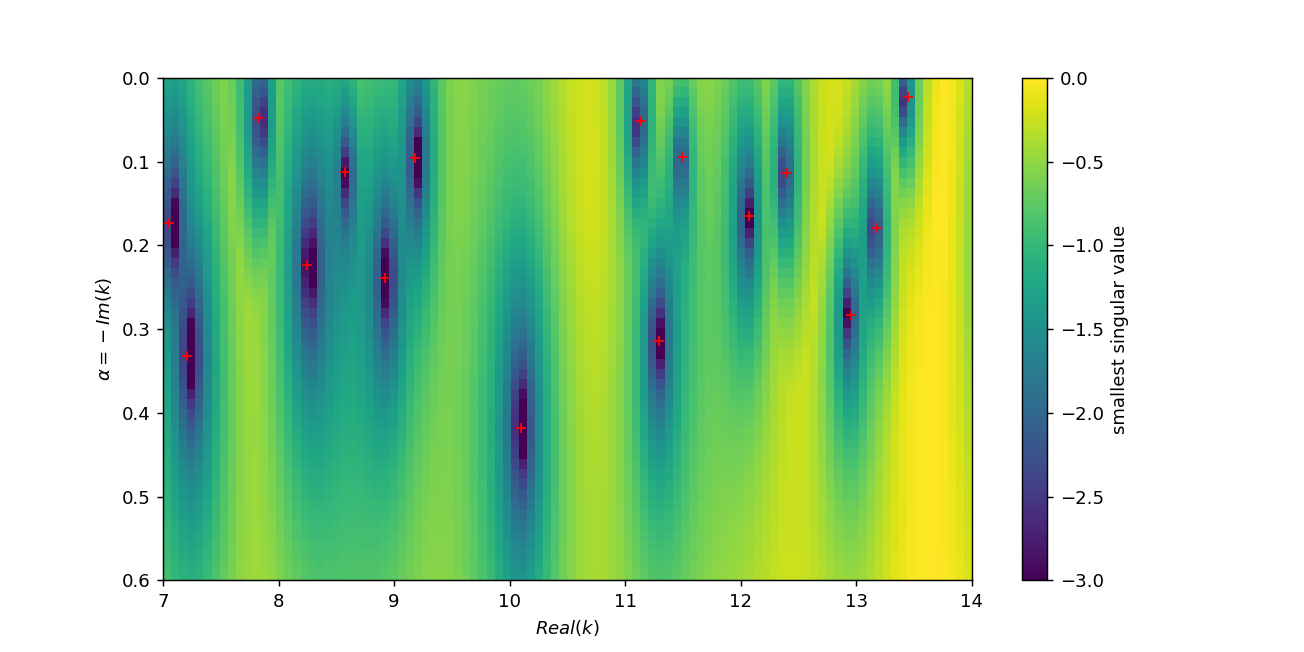

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [6]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 100.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [8,9]  #edges to pump

#m = 0
#naq_u1.update_chi(modes[m])
#print("condition number no pump:", naq_u1.test_laplacian())
#
#naq_u1.pump_params['D0']         = 1e-2
#naq_u1.update_chi(modes[m])
#print("condition number with pump:", naq_u1.test_laplacian())


<IPython.core.display.Javascript object>


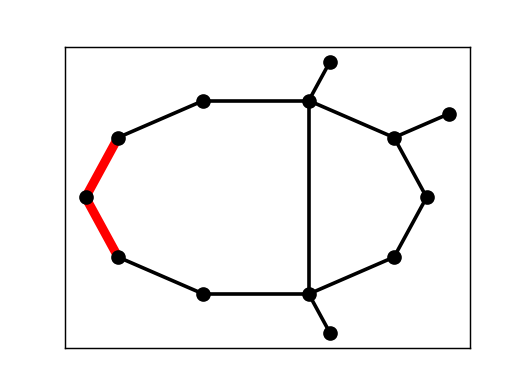

In [7]:
#plot the graph with the pump
plt.figure(figsize=(4,3))
#nx.draw(G, pos=pos, node_size=200)
nodes = nx.draw_networkx_nodes(G,pos=pos, node_color = 'k', node_size=50)# np.abs(phi)**2, cmap='plasma')
edges = nx.draw_networkx_edges(G,pos=pos, edge_color = 'k', width=2)

#get the edge list for the pump
edge_pump = []
for k, e in enumerate(G.edges):
    if k in naq_u1.pump_params['edges']:
        edge_pump.append(e)

edges_pump = nx.draw_networkx_edges(G,pos=pos, edgelist = edge_pump, edge_color = 'r', width=5)

plt.savefig('pump_shape.png')


In [8]:
#find the pump trajectories
params['s_size']    = 1e-3*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .1
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)

100%|██████████| 9/9 [00:46<00:00,  5.22s/it]


<IPython.core.display.Javascript object>


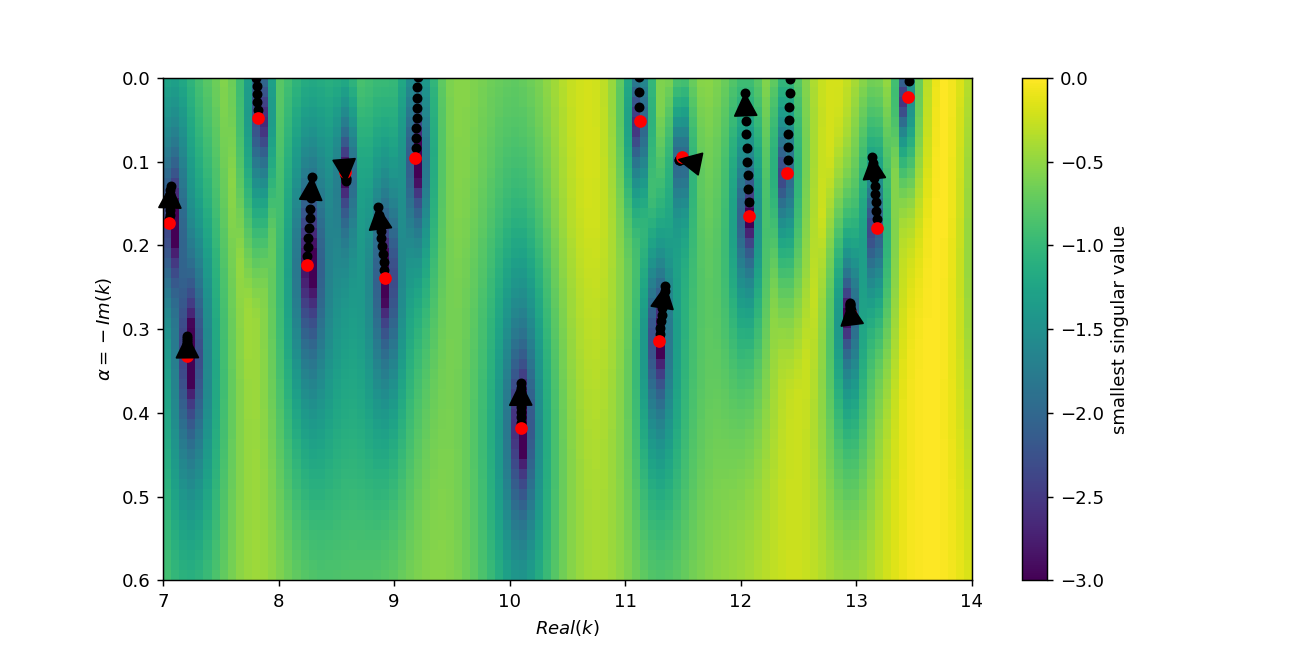

In [9]:
#plot the pump trajectories
naq_u1.plot_pump_traj( Ks, Alphas, s, modes, new_modes, estimate=False)

In [10]:
params['s_size']    = 1e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

  0%|          | 0/16 [00:00<?, ?it/s]

Start running many attempts (threshold search)
1 attempts to find a mode, think of fine tuning parameters! (threshold search)


100%|██████████| 16/16 [00:18<00:00,  1.68s/it]


<IPython.core.display.Javascript object>


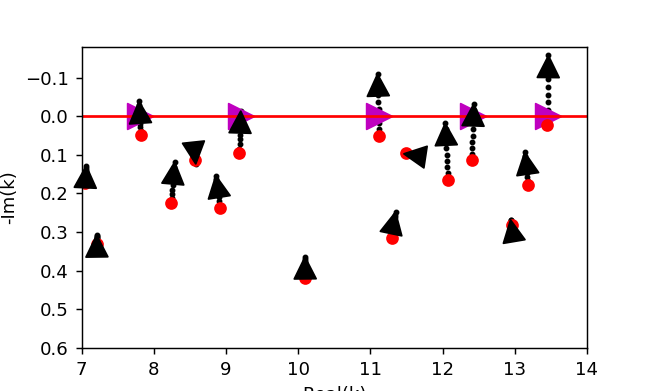

In [11]:
#plot the trajectories and the lasing modes
plt.figure(figsize=(5,3))
naq_u1.plot_pump_traj_reduced(  Ks, Alphas, s, modes, new_modes, estimate=False)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.18])
plt.axhline(0, c='r')

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
        
#plt.axis([13.3, 13.5, 0.03, -0.01])
plt.xlabel('Real(k)')
plt.ylabel('-Im(k)')
plt.savefig('mode_trajectories.png', bbox_inches='tight')

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [12]:
#create a smaller list of possible lasing modes out of all the passive modes 
# (remove the ones with -1 from the search above)

th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.34544994e+01  1.26259495e-06]
 [ 7.80903267e+00 -1.31000336e-07]
 [ 1.11186108e+01 -1.87726687e-06]
 [ 9.20273464e+00  1.44485554e-05]
 [ 1.24269855e+01  6.79941376e-05]]
[0.01300995 0.05520299 0.03279286 0.08779149 0.0788133 ]


k= (13.45449943932379-1.2625949453336422e-06j)


<IPython.core.display.Javascript object>


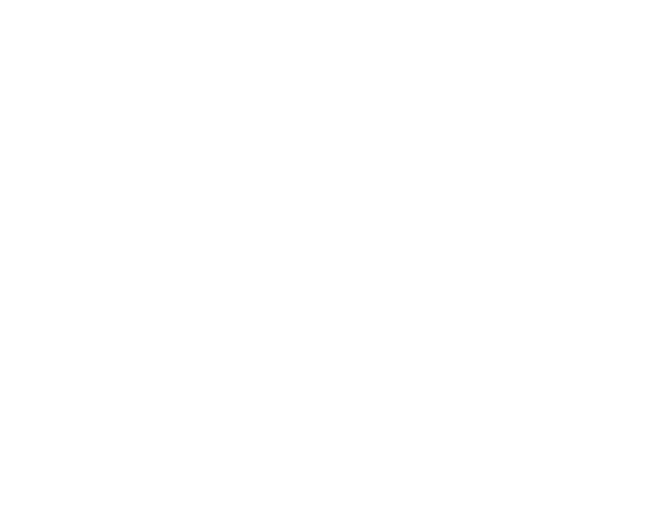

k= (7.809032667062809+1.310003355341205e-07j)


<IPython.core.display.Javascript object>


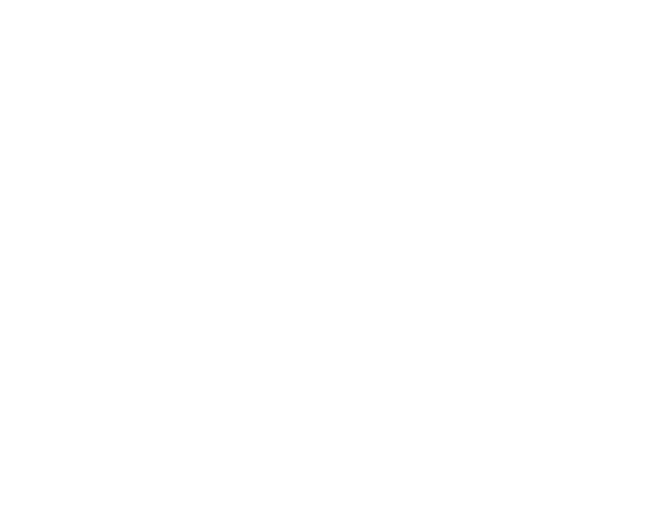

k= (11.118610774920773+1.8772668711095845e-06j)


<IPython.core.display.Javascript object>


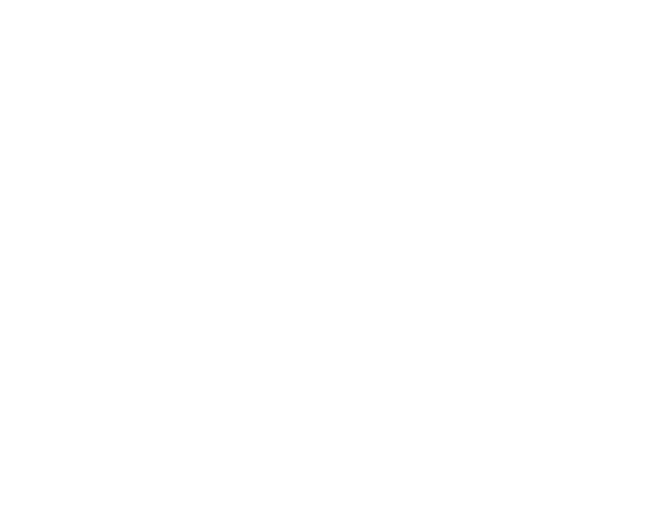

k= (9.20273463634566-1.4448555418648095e-05j)


<IPython.core.display.Javascript object>


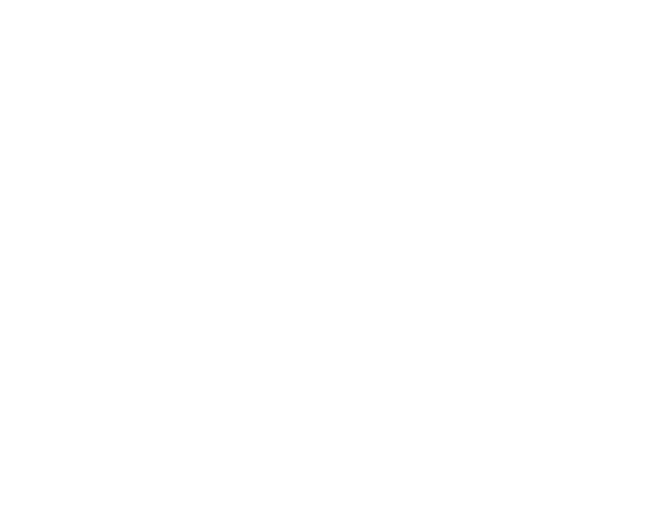

k= (12.426985462573523-6.79941375996079e-05j)


<IPython.core.display.Javascript object>


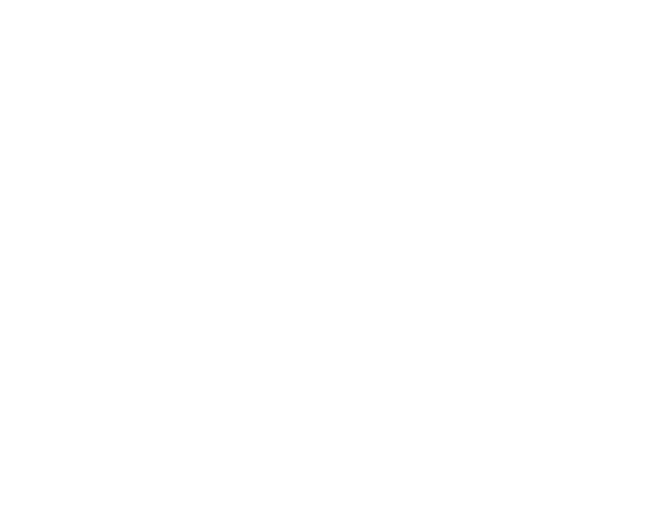

In [13]:

#for each mode, save a figure for it
if not os.path.isdir('lasing_modes'):
    os.mkdir('lasing_modes')

for m in range(len(th_modes_selec)):
    print("k=", th_modes_selec[m,0]-1j*th_modes_selec[m,1])
    naq_u1.pump_params['D0'] = D0_th_selec[m]
                
    naq_u1.update_chi(th_modes_selec[m])
    naq_u1.update_laplacian()
    phi = naq_u1.compute_solution()
    edge_color = naq_u1.compute_edge_mean_E2()

    plt.figure(figsize=(5,4))
    nodes = nx.draw_networkx_nodes(naq_u1.graph, pos=naq_u1.pos, node_color = 'k', node_size=10)# np.abs(phi)**2, cmap='plasma')
    edges_k = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edge_color = 'k', width=2)

    #plot the edge with large field last (or on top)
    order_edges = np.argsort(edge_color)
    for i in order_edges:
        for ei, e in enumerate(naq_u1.graph.edges):
            if ei == i:
                edges = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edgelist = [e,], edge_color = [edge_color[i],], edge_cmap=plt.get_cmap('Greens'), width=8, alpha=0.7, edge_vmin=0, edge_vmax = np.max(edge_color))
    
    #plt.colorbar(nodes, label=r'Node $|E_i|^2$')
    plt.colorbar(edges, label=r'Edges $\frac{1}{l_{ij}}\int_0^{l_{ij}}|E_{ij}(x)|^2 dx$')

    plt.title("k="+str(np.around(th_modes_selec[m,0],2)-1j*np.around(th_modes_selec[m,1],3)))
    plt.axis('off')
    plt.savefig('lasing_modes/mode_'+str(m)+'.svg')
    plt.close()


In [14]:

T = naq_u1.T_matrix( th_modes_selec, D0_th_selec)


In [15]:

D0_steps = 10
D0_max = .12

I = naq_u1.modal_intensities( D0_max, D0_steps, th_modes_selec, D0_th_selec)

<IPython.core.display.Javascript object>


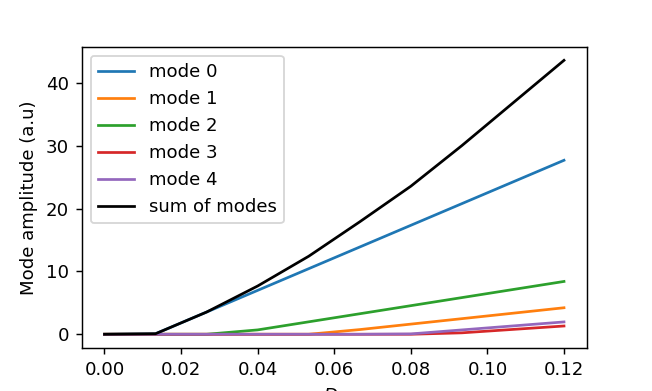

In [16]:
plt.figure(figsize=(5,3))
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, (I[i]), '-', label='mode '+str(i))
    
plt.plot(D0s,I.sum(0),'-k',label='sum of modes')
plt.legend(loc='best')
plt.xlabel('$D_0$')
plt.ylabel('Mode amplitude (a.u)')
plt.savefig('modal_amplitudes.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


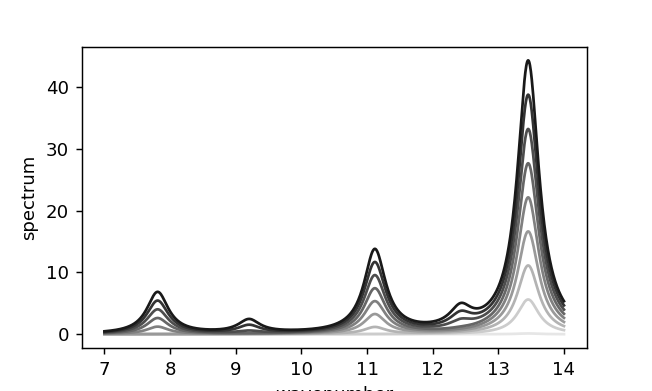

In [20]:
def lorentzian(k, k0, gamma):
    return 1./np.pi * gamma / ( ( k-k0)**2 + gamma**2 ) 

Ks = np.linspace(7,14, 1000)
D0 = 90
spectr = np.zeros([np.shape(I)[1], len(Ks)])
for i, m in enumerate(th_modes_selec):
    for d in range(np.shape(I)[1]):
        spectr[d] += I[i,d]*lorentzian(Ks, m[0], 0.2)
        
plt.figure(figsize=(5,3))
for d in range(np.shape(I)[1]):
    plt.plot(Ks, spectr[d] , c=str(1-d/np.shape(I)[1]))
plt.xlabel('wavenumber')
plt.ylabel('spectrum')
plt.savefig('spectrum.png', bbox_inches='tight')